In [1]:
import os

os.chdir('..')
datadir = 'data'

import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as ctx
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime, timedelta
from shapely.geometry import Point

In [2]:
DEFAULT_CRS = 'EPSG:3857'
SEASONS = ['summer', 'autumn']

In [3]:
pd.options.display.precision = 1

# Import PurpleAir and AirNow data archives

## Formatting and cleaning functions

In [4]:
def lower_and_underscore(s):
    return str(s).strip().lower().replace(' ','_')

def import_archive_data(fname, season):
    df = pd.read_csv(fname)
    df['season'] = season
    df.columns = df.columns.to_series().apply(lower_and_underscore)
    return df

## Import AirNow sensor data

In [5]:
# Import summer and autumn AirNow data into a single DataFrame
df_an = pd.DataFrame()
for season in SEASONS:
    fname = os.path.join(datadir, f"{season}_2021_airnow.csv")
    df_tmp = pd.read_csv(fname, index_col=0, parse_dates=['DateTime'])
    df_tmp['season'] = season
    df_tmp.columns = df_tmp.columns.to_series().apply(lower_and_underscore)    
    df_an = df_an.append(df_tmp)

df_an.head()

,latitude,longitude,datetime,parameter,concentration,unit,aqi,category,season
0,42.0,-87.9,2021-07-04 02:00:00,OZONE,31.0,PPB,29,1,summer
1,42.1,-87.9,2021-07-04 02:00:00,PM2.5,10.5,UG/M3,44,1,summer
2,42.1,-87.9,2021-07-04 02:00:00,OZONE,35.0,PPB,32,1,summer
3,41.9,-87.8,2021-07-04 02:00:00,OZONE,34.0,PPB,31,1,summer
4,41.9,-87.7,2021-07-04 02:00:00,PM2.5,5.3,UG/M3,22,1,summer


In [6]:
# Get PM2.5-specific rows/cols
colList = ['latitude', 'longitude', 'datetime', 'concentration', 'season']
df_an_pm25 = df_an.loc[df_an['parameter'] == 'PM2.5', :][colList].sort_values(by=['latitude', 'datetime']).reset_index().copy()

df_an_pm25.head()

,index,latitude,longitude,datetime,concentration,season
0,732,41.7,-87.7,2021-07-06 20:00:00,11.8,summer
1,743,41.7,-87.7,2021-07-06 21:00:00,13.6,summer
2,755,41.7,-87.7,2021-07-06 22:00:00,12.3,summer
3,768,41.7,-87.7,2021-07-06 23:00:00,10.6,summer
4,779,41.7,-87.7,2021-07-07 00:00:00,12.4,summer


In [7]:
# Get list of unique sensor coordinates and sort from southernmost to northermost
sensorCoords_an = df_an_pm25[['latitude', 'longitude']].drop_duplicates().sort_values(by='latitude').reset_index()
locations_an = {0: "Alsip",
                1: "Ashburn",
                2: "Cicero",
                3: "Humbolt Park/Hermosa",
                4: "Des Plaines"}               
sensorCoords_an['location'] = locations_an.values()

display(sensorCoords_an)

,index,latitude,longitude,location
0,0,41.7,-87.7,Alsip
1,1242,41.8,-87.7,Ashburn
2,2548,41.9,-87.7,Cicero
3,3850,41.9,-87.7,Humbolt Park/Hermosa
4,5112,42.1,-87.9,Des Plaines


In [8]:
df_an_pm25 = df_an_pm25.merge(sensorCoords_an[['latitude', 'longitude', 'location']],
                              how='outer', on=['latitude', 'longitude'])

display(df_an_pm25)

,index,latitude,longitude,datetime,concentration,season,location
0,732,41.7,-87.7,2021-07-06 20:00:00,11.8,summer,Alsip
1,743,41.7,-87.7,2021-07-06 21:00:00,13.6,summer,Alsip
2,755,41.7,-87.7,2021-07-06 22:00:00,12.3,summer,Alsip
3,768,41.7,-87.7,2021-07-06 23:00:00,10.6,summer,Alsip
4,779,41.7,-87.7,2021-07-07 00:00:00,12.4,summer,Alsip
...,...,...,...,...,...,...,...
6411,3056,42.1,-87.9,2021-10-31 23:00:00,3.2,autumn,Des Plaines
6412,3069,42.1,-87.9,2021-11-01 00:00:00,3.7,autumn,Des Plaines
6413,3082,42.1,-87.9,2021-11-01 01:00:00,4.3,autumn,Des Plaines
6414,3094,42.1,-87.9,2021-11-01 02:00:00,4.6,autumn,Des Plaines


## Import PurpleAir sensor data

In [9]:
# Pull list of PurpleAir sensors from JSON file
df_sensors = pd.read_json(os.path.join(datadir, "pa_sensors.json"))
df_sensors.columns = df_sensors.columns.to_series().apply(lower_and_underscore)
df_sensors.rename(columns={'sensorid': 'sensor'}, inplace=True)

# Merge with coordinates for sensors locations (based on looking up intersections on Google Maps)
sensorDict = {0: (41.82863695731357, -87.66789654012659),
                1: (41.82492553658286, -87.67390925492755),
                2: (41.82283856567223, -87.67588687024907)}

df_sensors['coordinates'] = df_sensors.index.map(sensorDict)
df_sensors['latitude'] = df_sensors['coordinates'].apply(lambda x: x[0])
df_sensors['longitude'] = df_sensors['coordinates'].apply(lambda x: x[1])

print(df_sensors[['sensor', 'neighborhood', 'location', 'latitude', 'longitude']])

   sensor   neighborhood               location  latitude  longitude
0   96035  McKinley Park       36th and Paulina      41.8      -87.7
1   96395  McKinley Park      38th & Winchester      41.8      -87.7
2   94975  McKinley Park  39th and Damen (NLEI)      41.8      -87.7


In [10]:
# Import summer and autumn PurpleAir parent (main sensor) data into a single DataFrame,
# merging with sensor coordinates
df_pa = pd.DataFrame()
for season in SEASONS:
    fname = os.path.join(datadir, f"{season}_2021_pa_parent.csv")
    df_tmp = pd.read_csv(fname, parse_dates=['created_at'])
    df_tmp['season'] = season
    df_tmp.columns = df_tmp.columns.to_series().apply(lower_and_underscore)
    df_tmp.rename(columns={'created_at': 'datetime'}, inplace=True)
    df_tmp = df_tmp.merge(df_sensors[['sensor', 'latitude', 'longitude', 'location']], how='outer', on='sensor')
    df_pa = df_pa.append(df_tmp)

df_pa.head()   

,unnamed:_0,datetime,entry_id,pm1.0_(cf=1)_ug/m3,pm2.5_(cf=1)_ug/m3,pm10.0_(cf=1)_ug/m3,uptimeminutes,adc,temperature_f,humidity_%,pm2.5_(cf=atm)_ug/m3,sensor,channel,season,latitude,longitude,location
0,14601.0,2021-07-25 00:01:48+00:00,NaN,8.6,14.7,14.8,496.0,-63.0,87.0,65.0,14.7,96035,1.3e+06,summer,41.8,-87.7,36th and Paulina
1,14602.0,2021-07-25 00:03:48+00:00,NaN,8.5,13.3,14.1,498.0,-64.0,87.0,66.0,13.3,96035,1.3e+06,summer,41.8,-87.7,36th and Paulina
2,14603.0,2021-07-25 00:05:48+00:00,NaN,7.8,13.7,15.0,500.0,-63.0,86.0,67.0,13.7,96035,1.3e+06,summer,41.8,-87.7,36th and Paulina
3,14604.0,2021-07-25 00:07:48+00:00,NaN,10.4,18.1,19.8,502.0,-62.0,87.0,67.0,18.1,96035,1.3e+06,summer,41.8,-87.7,36th and Paulina
4,14605.0,2021-07-25 00:09:48+00:00,NaN,10.3,18.7,19.6,504.0,-65.0,87.0,66.0,18.7,96035,1.3e+06,summer,41.8,-87.7,36th and Paulina


In [11]:
# Get PM2.5-specific rows/cols
colList = ['latitude', 'longitude', 'location', 'datetime', 'pm2.5_(cf=1)_ug/m3', 'season']
df_pa_pm25 = df_pa[colList].sort_values(by=['latitude', 'datetime']).reset_index().copy()
df_pa_pm25.rename(columns={'pm2.5_(cf=1)_ug/m3': 'concentration'},  inplace=True)

df_pa_pm25.head()

,index,latitude,longitude,location,datetime,concentration,season
0,54045,41.8,-87.7,39th and Damen (NLEI),2021-10-05 00:00:02+00:00,7.6,autumn
1,54046,41.8,-87.7,39th and Damen (NLEI),2021-10-05 00:02:02+00:00,8.1,autumn
2,54047,41.8,-87.7,39th and Damen (NLEI),2021-10-05 00:04:02+00:00,8.4,autumn
3,54048,41.8,-87.7,39th and Damen (NLEI),2021-10-05 00:06:02+00:00,9.1,autumn
4,54049,41.8,-87.7,39th and Damen (NLEI),2021-10-05 00:08:02+00:00,8.3,autumn


In [12]:
# Get list of unique sensor coordinates
sensorCoords_pa = df_pa_pm25[['latitude', 'longitude', 'location']].drop_duplicates().sort_values(by='latitude').reset_index()
display(sensorCoords_pa)

,index,latitude,longitude,location
0,0,41.8,-87.7,39th and Damen (NLEI)
1,18929,41.8,-87.7,38th & Winchester
2,59164,41.8,-87.7,36th and Paulina


# Compare sensor locations

In [13]:
# Convert AirNow sensor locations to GeoDataFrame
gdf_an = gpd.GeoDataFrame(
    sensorCoords_an,
    crs='EPSG:4326',
    geometry=gpd.points_from_xy(sensorCoords_an.longitude, sensorCoords_an.latitude), 
).to_crs(DEFAULT_CRS)

# Convert PurpleAir sensor locations to GeoDataFrame
gdf_pa = gpd.GeoDataFrame(
    sensorCoords_pa,
    crs='EPSG:4326',
    geometry=gpd.points_from_xy(sensorCoords_pa.longitude, sensorCoords_pa.latitude), 
).to_crs(DEFAULT_CRS)

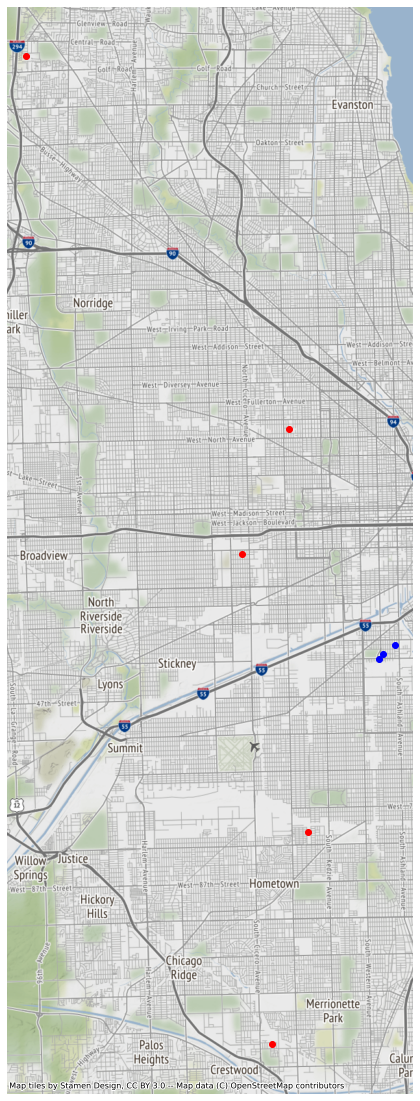

In [14]:
# Plot sensor locations: AirNow in red, PurpleAir in Blue
ax = gdf_an.plot(
    figsize=(20, 20), 
    color='red'
)
gdf_pa.plot(
    ax=ax, 
    color='blue'
)

# Add background map
ctx.add_basemap(ax)

ax.set_axis_off()

plt.savefig('figures/sensor_locations_PM.png', bbox_inches='tight', dpi=600)

# Plot timeseries data

In [15]:
dfs = {'an': df_an_pm25,
       'pa': df_pa_pm25}

In [16]:
def plot_seasonal_trends(df_data, df_sensors):
    """Plot data for season, for each sensor separately"""
    
    nSensors = len(df_sensors.index)
    figure, axis = plt.subplots(nSensors)
    figure.set_figheight(10)

    dataMin = min(df_data['concentration'])
    dataMax = max(df_data['concentration'])
    buffer = 0.05*(dataMax - dataMin)
    
    colors = ['green', 'pink']
    for i, sensor in df_sensors.iterrows():
        # Get data corresponding to current sensor
        df_sensor = df_data.loc[(df_data['latitude'] == sensor['latitude']) &
                                (df_data['longitude'] == sensor['longitude'])]
        
        # Plot data for each season separately
        for j, season in enumerate(SEASONS):
            df_season = df_sensor.loc[df_sensor['season'] == season].copy()
            df_season.sort_values(by='datetime', inplace=True)
            
            axis[i].plot(df_season['datetime'], df_season['concentration'], color=colors[j])
        
        # Format plot
        axis[i].set_ylabel("Concentration\n(ug/m3)")
        axis[i].set_title(sensor['location'])
        axis[i].set_ylim([dataMin - buffer, dataMax + buffer])
        if i < nSensors-1:
            axis[i].set_xticklabels([])
        else:
            axis[i].xaxis.set_major_formatter(mdates.DateFormatter("%m/%d/%Y"))
            plt.xticks(rotation=60) 

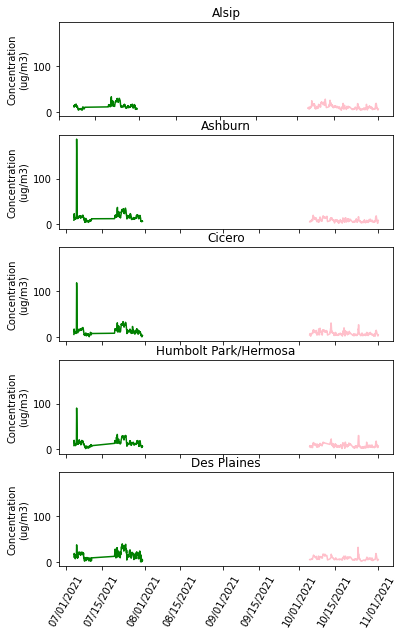

In [17]:
plot_seasonal_trends(df_an_pm25, sensorCoords_an)

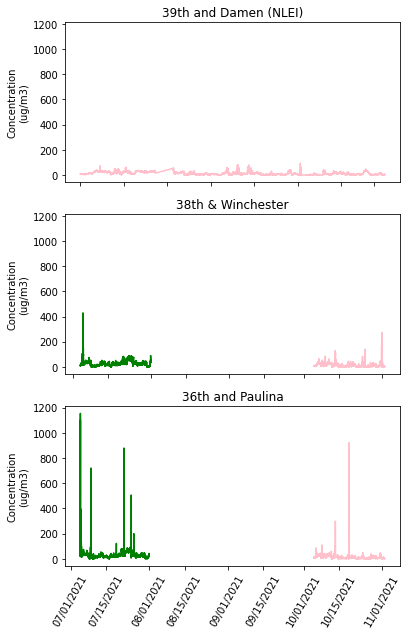

In [18]:
plot_seasonal_trends(df_pa_pm25, sensorCoords_pa)

# How correlated are PM2.5 concentration timeseries for different sensors?
For each season, compute the Pearson correlation coefficient for each pair of sensors. This requires interpolating the data over the common timespan with 2-hour intervals.

## Compute and compare rolling average
AirNow sensors collect data every two hours, PurpleAir sensors every two minutes. Get rolling average with a 24 hour window.

In [19]:
windows = {'an': 12,
           'pa': 30*24}

for key, df in dfs.items():
    df['concentration_rolling'] = df['concentration'].rolling(window=windows[key]).mean()

In [20]:
## Compute aggregate statistics

In [21]:
# Display aggregate statistics
for df in dfs.values():
    gb = df.groupby(['location', 'season']).agg(
        {'concentration' : ['mean', 'std', 'min', 'max'],
         'concentration_rolling' : ['mean', 'std', 'min', 'max'],
         'datetime': ['min', 'max']})
    display(gb)

concentration                    \
                                     mean   std  min    max   
location             season                                   
Alsip                autumn          10.5   4.4  3.8   27.8   
                     summer          14.1   6.3  3.6   33.0   
Ashburn              autumn           8.7   3.6  2.4   19.8   
                     summer          18.1  12.4  4.3  186.3   
Cicero               autumn           7.7   4.3  1.3   30.3   
                     summer          14.4   9.9  0.0  118.0   
Des Plaines          autumn           7.6   4.0  1.2   31.5   
                     summer          16.5   9.0  0.0   39.1   
Humbolt Park/Hermosa autumn           8.1   4.1  1.7   30.0   
                     summer          15.1   8.1  1.5   90.1   

                            concentration_rolling                  \
                                             mean  std  min   max   
location             season                                         
Alsip                autumn                  10.5  3.8  4.5  20.2   
                     summer                  14.2  6.1  4.9  29.2   
Ashburn              autumn                   8.7  3.0  4.1  16.4   
                     summer                  18.0  9.0  6.0  67.5   
Cicero               autumn                   7.7  3.4  1.9  20.2   
                     summer                  14.5  7.8  1.0  45.5   
Des Plaines          autumn                   7.6  3.4  1.5  19.5   
                     summer                  16.5  8.4  0.6  36.9   
Humbolt Park/Hermosa autumn                   8.1  3.3  3.6  21.6   
                     summer                  15.1  6.8  3.9  36.8   

                                       datetime                      
                                            min                 max  
location             season                                          
Alsip                autumn 2021-10-05 02:00:00 2021-11-01 03:00:00  
                     summer 2021-07-06 20:00:00 2021-07-31 03:00:00  
Ashburn              autumn 2021-10-05 02:00:00 2021-11-01 03:00:00  
                     summer 2021-07-04 02:00:00 2021-07-31 03:00:00  
Cicero               autumn 2021-10-05 02:00:00 2021-11-01 03:00:00  
                     summer 2021-07-04 02:00:00 2021-07-31 03:00:00  
Des Plaines          autumn 2021-10-05 02:00:00 2021-11-01 03:00:00  
                     summer 2021-07-04 02:00:00 2021-07-31 03:00:00  
Humbolt Park/Hermosa autumn 2021-10-05 02:00:00 2021-11-01 03:00:00  
                     summer 2021-07-04 02:00:00 2021-07-31 03:00:00

concentration                         \
                                      mean   std      min     max   
location              season                                        
36th and Paulina      autumn          12.5  14.6  0.0e+00   922.3   
                      summer          26.5  27.0  3.0e-02  1154.5   
38th & Winchester     autumn          13.0  13.4  0.0e+00   272.7   
                      summer          26.0  21.9  0.0e+00   428.7   
39th and Damen (NLEI) autumn          12.2  10.7  0.0e+00    93.2   

                             concentration_rolling                   \
                                              mean   std  min   max   
location              season                                          
36th and Paulina      autumn                  12.8   8.2  0.8  34.7   
                      summer                  26.3  14.9  3.3  67.2   
38th & Winchester     autumn                  13.2   8.4  1.0  36.8   
                      summer                  26.3  15.7  2.9  69.6   
39th and Damen (NLEI) autumn                  12.4   7.3  1.0  28.8   

                                              datetime  \
                                                   min   
location              season                             
36th and Paulina      autumn 2021-10-05 00:01:52+00:00   
                      summer 2021-07-04 19:28:57+00:00   
38th & Winchester     autumn 2021-10-05 00:01:16+00:00   
                      summer 2021-07-04 00:01:03+00:00   
39th and Damen (NLEI) autumn 2021-10-05 00:00:02+00:00   

                                                        
                                                   max  
location              season                            
36th and Paulina      autumn 2021-11-01 23:58:26+00:00  
                      summer 2021-07-31 23:59:24+00:00  
38th & Winchester     autumn 2021-11-01 23:58:25+00:00  
                      summer 2021-07-31 23:59:07+00:00  
39th and Damen (NLEI) autumn 2021-11-01 23:58:26+00:00

## What is the correlation between sensors?

In [23]:
def plot_correlations(corrmatrix, axes=[], title=''):
    """Plot correlation matrix"""
    plt.figure()
    fig = sns.heatmap(corrmatrix, cmap=sns.color_palette("Blues", as_cmap=True), vmin=0, vmax=1)
    plt.title(title)
    fig.xaxis.set_ticks_position("top")

In [24]:
def sensor_correlation_matrix(df_data, df_sensors):
    """For each season, find the correlation between sensors.
    This requires interpolation: finding the overlapping time period for each pair of sensors
    and interpolating the concentration data with 2-hour frequency.
    This is done both for the raw data and for 24-hour rolling average data. 
    """
    
    nSensors = len(df_sensors.index)
    nSeasons = len(SEASONS)
    
    correlations_raw = np.zeros([nSeasons, nSensors, nSensors])
    correlations_rolling = np.zeros([nSeasons, nSensors, nSensors])
    for i, season in enumerate(SEASONS):
        # Get data corresponding to current season
        df_season = df_data.loc[df_data['season'] == season].copy()
        df_season.sort_values(by='datetime', inplace=True)
        
        for j, sensor1 in df_sensors.iterrows():
            # Get data corresponding to current sensor
            df_sensor1 = df_season.loc[(df_season['latitude'] == sensor1['latitude']) &
                                       (df_season['longitude'] == sensor1['longitude'])]     
            
            for k, sensor2 in df_sensors.iterrows():
                # Correlate w/data for all sensors (including self)
                df_sensor2 = df_season.loc[(df_season['latitude'] == sensor2['latitude']) &
                                           (df_season['longitude'] == sensor2['longitude'])]
                
                # Find overlapping time period and interpolate 
                dtMin = max(min(df_sensor1['datetime']), min(df_sensor2['datetime']))
                dtMax = min(max(df_sensor1['datetime']), max(df_sensor2['datetime']))
                dtRange = pd.date_range(start=dtMin, end=dtMax, freq='2H')
                
                s1_interp_raw = np.interp(dtRange, df_sensor1['datetime'], df_sensor1['concentration'])
                s2_interp_raw = np.interp(dtRange, df_sensor2['datetime'], df_sensor2['concentration'])
                s1_interp_rolling = np.interp(dtRange, df_sensor1['datetime'], df_sensor1['concentration_rolling'])
                s2_interp_rolling = np.interp(dtRange, df_sensor2['datetime'], df_sensor2['concentration_rolling'])
                
                # Find Pearson correlation coefficients and add to correlation matrix
                correlations_raw[i, j, k] = pd.Series(s1_interp_raw).corr(pd.Series(s2_interp_raw))
                correlations_rolling[i, j, k] = pd.Series(s1_interp_rolling).corr(pd.Series(s2_interp_rolling))
    
    # Plot correlation matrices
    for i, season in enumerate(SEASONS):
        plot_correlations(correlations_raw[0,:,:], title=f'Raw data, {season}')
        plot_correlations(correlations_rolling[1,:,:], title=f'Rolling average, {season}')

AirNow sensors:


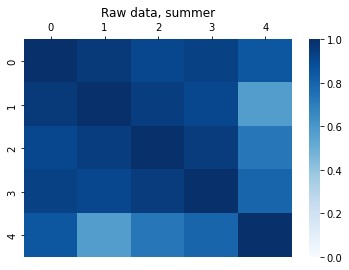

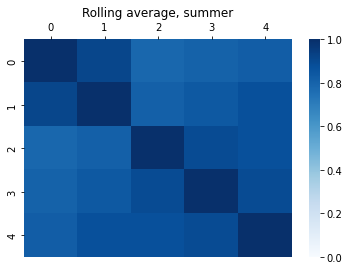

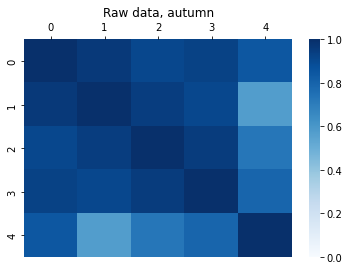

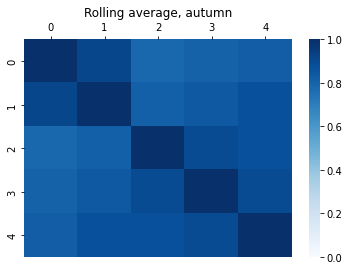

In [25]:
print("AirNow sensors:")
sensor_correlation_matrix(df_an_pm25, sensorCoords_an)

## TODO: Is the correlation coefficient correlated with distance between sensors? 

## TODO: Are there seasonal differences between summer and fall PM2.5 concentrations?